## Pre-processing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option('display.max_columns', 100)

In [27]:
# import preprocessing routine
from preprocess_module import fraud_preprocessor

# call preprocessor 
full_df = fraud_preprocessor(i_flag=0)

## Feature Engineering

In [28]:
# create physician count column 
phys_count = full_df.groupby(['AttendingPhysician', 'Provider'])['AttendingPhysician'].count()\
           .reset_index(name='Phys_Count').groupby(['Provider'])['Phys_Count'].count().reset_index()


In [29]:
# create patient count column 
patient_count = full_df.groupby(['Provider', 'BeneID'])['BeneID'].count().reset_index(name='Patient_Count')\
                .groupby('Provider')['Patient_Count'].count().reset_index()

train_features1 = pd.merge(phys_count, patient_count, on='Provider')

In [30]:
patient_count.head()

,Provider,Patient_Count
0,PRV51001,24
1,PRV51003,117
2,PRV51004,138
3,PRV51005,495
4,PRV51007,58


In [31]:
# create claim count column 
claim_count = full_df.groupby('Provider')['ClaimID'].count().reset_index(name='Claim_Count')

train_features2 = pd.merge(train_features1, claim_count, on='Provider')
train_features2.head()

,Provider,Phys_Count,Patient_Count,Claim_Count
0,PRV51001,14,24,36
1,PRV51003,44,117,212
2,PRV51004,38,138,228
3,PRV51005,7,495,1545
4,PRV51007,10,58,107


In [32]:
##create service type column
prov_type = full_df.groupby(['Provider', 'PatientType'])['BeneID'].count().reset_index(name='').drop('', axis=1)
prov_type.head()

# create a dictionary provider by service type
lst_prov_type = list(zip(prov_type['Provider'], prov_type['PatientType']))

# feed in empty dict with values inpatient, outpatient, or both
prov_type_dict = {}

for i in lst_prov_type:
    if i[0] not in prov_type_dict:
        prov_type_dict[i[0]]= i[1]    
    else:
        prov_type_dict[i[0]] = 'Both_Service'
        

# creaete new column type of service by povider
service_type = pd.DataFrame(prov_type_dict.keys(), prov_type_dict.values()).reset_index().\
               rename(columns={'index':'Service_Type', 0:'Provider'})

# add Service column 
train_features3 = pd.merge(train_features2, service_type, on='Provider')


In [33]:
#create dummy for service types

dummy = pd.get_dummies(service_type['Service_Type'])
dummy_type = pd.concat([service_type, dummy], axis=1)
dummy_type = dummy_type.drop('Service_Type', axis=1)

# add Service column 
train_features3 = pd.merge(train_features3, dummy_type, on='Provider')

train_features3.head()

,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,Both_Service,Inpatient,Outpatient
0,PRV51001,14,24,36,Both_Service,1,0,0
1,PRV51003,44,117,212,Both_Service,1,0,0
2,PRV51004,38,138,228,Outpatient,0,0,1
3,PRV51005,7,495,1545,Outpatient,0,0,1
4,PRV51007,10,58,107,Both_Service,1,0,0


In [34]:
# Duplicate Claims 
full_df2 = full_df.copy()
full_df2['all_duplicates'] = full_df2.duplicated(subset = ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'ClmAdmitDiagnosisCode', 'BeneID', 'Provider'], keep=False)

In [35]:
#duplicate claims
Duplicates = full_df2[full_df2.all_duplicates == True].groupby('Provider')['BeneID'].count().reset_index(name='DuplicateClaims')

train_features4 = pd.merge(train_features3, Duplicates, on = 'Provider')

#duplicate claims percentage 
train_features4['Duplicate_Claims_Percent'] = pd.DataFrame(round((train_features4['DuplicateClaims'] \
                                                          / train_features4['Claim_Count']), 2))
train_features4.head()

,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,Both_Service,Inpatient,Outpatient,DuplicateClaims,Duplicate_Claims_Percent
0,PRV51001,14,24,36,Both_Service,1,0,0,22,0.61
1,PRV51003,44,117,212,Both_Service,1,0,0,160,0.75
2,PRV51004,38,138,228,Outpatient,0,0,1,158,0.69
3,PRV51005,7,495,1545,Outpatient,0,0,1,764,0.49
4,PRV51007,10,58,107,Both_Service,1,0,0,70,0.65


In [36]:
# Claim Duration 
Claim_dur = full_df2.groupby('Provider')['ClaimDuration'].agg('mean').reset_index(name='AvgClaimDuration')
train_features5 = pd.merge(train_features4, Claim_dur, on = 'Provider')
train_features5.head()

,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,Both_Service,Inpatient,Outpatient,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration
0,PRV51001,14,24,36,Both_Service,1,0,0,22,0.61,1.194444
1,PRV51003,44,117,212,Both_Service,1,0,0,160,0.75,3.816038
2,PRV51004,38,138,228,Outpatient,0,0,1,158,0.69,1.197368
3,PRV51005,7,495,1545,Outpatient,0,0,1,764,0.49,1.071197
4,PRV51007,10,58,107,Both_Service,1,0,0,70,0.65,1.289720


In [37]:
full_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimMonth,HospitalDuration,ClaimDuration,PatientType,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,None,None,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,None,None,None,None,None,None,None,4,6.0,6,Inpatient,1943-01-01,0,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000.0,3204.0,60.0,70.0,1
1,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,None,None,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,None,None,None,None,None,None,None,4,6.0,6,Inpatient,1943-01-01,0,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000.0,3204.0,60.0,70.0,1
2,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000.0,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,None,7769.0,5849.0,None,None,None,None,1,12.0,12,Inpatient,1913-12-01,0,2,1,0,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000.0,1068.0,100.0,20.0,1
3,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000.0,PHY334706,PHY334706,None,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,None,9338.0,None,None,None,None,None,10,18.0,18,Inpatient,1922-10-01,0,1,1,0,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000.0,1068.0,1050.0,540.0,1
4,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000.0,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,None,None,None,8154.0,None,None,None,None,None,10,4.0,4,Inpatient,1930-07-01,0,2,1,0,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000.0,2136.0,450.0,160.0,1


In [38]:
# Average Cost (reimbursed + deductible) across Providers
full_df2['TotalCharge'] = full_df2['InscClaimAmtReimbursed'] + full_df2['DeductibleAmtPaid']
print('Average Charges of Fraudulent and Non-Fraudulent Providers: \n', full_df2.groupby('PotentialFraud')['TotalCharge'].agg('mean'))
AvgCharge = full_df2.groupby('Provider')['TotalCharge'].agg('mean').reset_index(name='Avg_Cost')
train_features6 = pd.merge(train_features5, AvgCharge, on = 'Provider')
train_features6.head()

Average Charges of Fraudulent and Non-Fraudulent Providers: 
 PotentialFraud
0     813.991093
1    1545.522275
Name: TotalCharge, dtype: float64


,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,Both_Service,Inpatient,Outpatient,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost
0,PRV51001,14,24,36,Both_Service,1,0,0,22,0.61,1.194444,4684.833333
1,PRV51003,44,117,212,Both_Service,1,0,0,160,0.75,3.816038,5040.405660
2,PRV51004,38,138,228,Outpatient,0,0,1,158,0.69,1.197368,356.140351
3,PRV51005,7,495,1545,Outpatient,0,0,1,764,0.49,1.071197,247.708738
4,PRV51007,10,58,107,Both_Service,1,0,0,70,0.65,1.289720,652.037383


In [39]:
#age column
claim_start = full_df['ClaimStartDt'].apply(pd.to_datetime, errors='coerce', format='%Y-%m-%d')
birth_date = full_df['DOB']

full_df['Age'] = claim_start - birth_date
full_df['Age'] = full_df['Age'] / np.timedelta64(1, 'Y')

#average age column 
avg_age = full_df.groupby(['Provider', 'BeneID'])['Age'].mean().reset_index(name = "Avg_Age").dropna()\
          .groupby('Provider')['Avg_Age'].mean().reset_index()

avg_age['Avg_Age'] = avg_age['Avg_Age'].astype(int)


train_features7 = pd.merge(train_features6, avg_age, on='Provider')
train_features7.head()

,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,Both_Service,Inpatient,Outpatient,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age
0,PRV51001,14,24,36,Both_Service,1,0,0,22,0.61,1.194444,4684.833333,78
1,PRV51003,44,117,212,Both_Service,1,0,0,160,0.75,3.816038,5040.405660,68
2,PRV51004,38,138,228,Outpatient,0,0,1,158,0.69,1.197368,356.140351,72
3,PRV51005,7,495,1545,Outpatient,0,0,1,764,0.49,1.071197,247.708738,70
4,PRV51007,10,58,107,Both_Service,1,0,0,70,0.65,1.289720,652.037383,67


In [40]:
#create gender columns 
gender1 = full_df[['Provider', 'BeneID', 'Gender']].loc[full_df['Gender'] == 1].groupby('Provider')['BeneID']\
          .nunique().to_frame().reset_index().rename(columns = {'BeneID': 'Gender1'})

gender2 = full_df[['Provider', 'BeneID', 'Gender']].loc[full_df['Gender'] == 2].groupby('Provider')['BeneID']\
          .nunique().to_frame().reset_index().rename(columns = {'BeneID': 'Gender2'})

#merge gender1 and gender2
gender = pd.merge(gender1, gender2, on='Provider')

train_features9 = pd.merge(train_features7, gender, on='Provider')
train_features9.head()

,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,Both_Service,Inpatient,Outpatient,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,Gender2
0,PRV51001,14,24,36,Both_Service,1,0,0,22,0.61,1.194444,4684.833333,78,9,15
1,PRV51003,44,117,212,Both_Service,1,0,0,160,0.75,3.816038,5040.405660,68,49,68
2,PRV51004,38,138,228,Outpatient,0,0,1,158,0.69,1.197368,356.140351,72,45,93
3,PRV51005,7,495,1545,Outpatient,0,0,1,764,0.49,1.071197,247.708738,70,208,287
4,PRV51007,10,58,107,Both_Service,1,0,0,70,0.65,1.289720,652.037383,67,27,31


In [41]:
#create race columns
race1 = full_df[['Provider', 'BeneID', 'Race']].loc[full_df['Race'] == 1].groupby('Provider')['BeneID']\
        .nunique().to_frame().reset_index().rename(columns = {'BeneID': 'Race1'})
race2 = full_df[['Provider', 'BeneID', 'Race']].loc[full_df['Race'] == 2].groupby('Provider')['BeneID']\
        .nunique().to_frame().reset_index().rename(columns = {'BeneID': 'Race2'})
race3 = full_df[['Provider', 'BeneID', 'Race']].loc[full_df['Race'] == 3].groupby('Provider')['BeneID']\
        .nunique().to_frame().reset_index().rename(columns = {'BeneID': 'Race3'})
race5 = full_df[['Provider', 'BeneID', 'Race']].loc[full_df['Race'] == 5].groupby('Provider')['BeneID']\
        .nunique().to_frame().reset_index().rename(columns = {'BeneID': 'Race5'})

#merge race columns
race = pd.merge(race1, race2, on='Provider')
race = pd.merge(race, race3, on='Provider')
race = pd.merge(race, race5, on='Provider')

train_features13 = pd.merge(train_features9, race, on='Provider')
train_features13.head()

,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,Both_Service,Inpatient,Outpatient,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,Gender2,Race1,Race2,Race3,Race5
0,PRV51017,114,420,763,Outpatient,0,0,1,496,0.65,1.460026,276.199214,72,183,237,336,82,1,1
1,PRV51081,4,131,364,Both_Service,1,0,0,328,0.90,1.634615,666.395604,70,62,69,105,23,1,2
2,PRV51123,21,28,43,Both_Service,1,0,0,24,0.56,3.069767,1090.511628,69,15,13,23,1,3,1
3,PRV51139,34,42,60,Both_Service,1,0,0,34,0.57,2.566667,1598.000000,74,18,24,34,4,3,1
4,PRV51140,6,394,697,Both_Service,1,0,0,420,0.60,2.226686,1060.065997,72,189,205,355,9,21,9


In [42]:
# create each chronic condition count column
conditions = full_df.groupby('Provider')[['ChronicCond_Alzheimer', 'ChronicCond_KidneyDisease',
                                         'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 
                                         'ChronicCond_Depression', 'ChronicCond_Diabetes',
                                         'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
                                         'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']].agg('sum')\
                                        .reset_index()


train_features23 = pd.merge(train_features13, conditions, on='Provider')
train_features23.head()

,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,Both_Service,Inpatient,Outpatient,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,Gender2,Race1,Race2,Race3,Race5,ChronicCond_Alzheimer,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
0,PRV51017,114,420,763,Outpatient,0,0,1,496,0.65,1.460026,276.199214,72,183,237,336,82,1,1,1193,1203,1427,1284,1218,1001,944,1253,1327,1453
1,PRV51081,4,131,364,Both_Service,1,0,0,328,0.90,1.634615,666.395604,70,62,69,105,23,1,2,555,531,696,627,568,472,427,627,629,678
2,PRV51123,21,28,43,Both_Service,1,0,0,24,0.56,3.069767,1090.511628,69,15,13,23,1,3,1,66,69,85,69,66,52,55,82,71,85
3,PRV51139,34,42,60,Both_Service,1,0,0,34,0.57,2.566667,1598.000000,74,18,24,34,4,3,1,98,95,111,104,85,73,72,103,108,115
4,PRV51140,6,394,697,Both_Service,1,0,0,420,0.60,2.226686,1060.065997,72,189,205,355,9,21,9,1113,1112,1282,1156,1095,888,873,1178,1158,1314


In [43]:
#import train label df
label_train_df = pd.read_csv('Train-1542865627584.csv')

#add label column
features = pd.merge(train_features23, label_train_df, on='Provider')
features.head()

,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,Both_Service,Inpatient,Outpatient,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,Gender2,Race1,Race2,Race3,Race5,ChronicCond_Alzheimer,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,PotentialFraud
0,PRV51017,114,420,763,Outpatient,0,0,1,496,0.65,1.460026,276.199214,72,183,237,336,82,1,1,1193,1203,1427,1284,1218,1001,944,1253,1327,1453,No
1,PRV51081,4,131,364,Both_Service,1,0,0,328,0.90,1.634615,666.395604,70,62,69,105,23,1,2,555,531,696,627,568,472,427,627,629,678,No
2,PRV51123,21,28,43,Both_Service,1,0,0,24,0.56,3.069767,1090.511628,69,15,13,23,1,3,1,66,69,85,69,66,52,55,82,71,85,No
3,PRV51139,34,42,60,Both_Service,1,0,0,34,0.57,2.566667,1598.000000,74,18,24,34,4,3,1,98,95,111,104,85,73,72,103,108,115,No
4,PRV51140,6,394,697,Both_Service,1,0,0,420,0.60,2.226686,1060.065997,72,189,205,355,9,21,9,1113,1112,1282,1156,1095,888,873,1178,1158,1314,No


In [44]:
#export features to csv file for modeling

#features.to_csv('Features.csv', index = False, header=True)

### Exploratory Data Analysis

Text(0, 0.5, 'Average Cost')

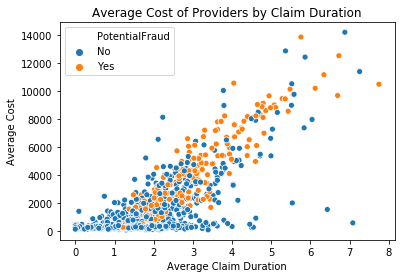

In [45]:
import matplotlib.pyplot as plt
sns.scatterplot(x='AvgClaimDuration', y='Avg_Cost', data=features, hue='PotentialFraud')
plt.title('Average Cost of Providers by Claim Duration')
plt.xlabel('Average Claim Duration')
plt.ylabel('Average Cost')

Text(0, 0.5, 'Duplications')

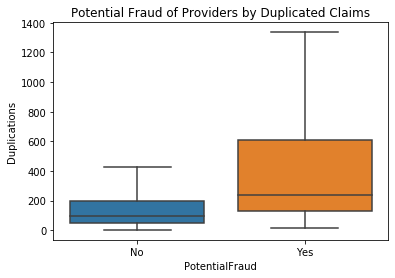

In [46]:
sns.boxplot(x='PotentialFraud', y='DuplicateClaims', data=features, showfliers=False)
plt.title('Potential Fraud of Providers by Duplicated Claims')
plt.ylabel('Duplications')

Text(0.5, 1.0, 'Fraudulent Providers Service Type')

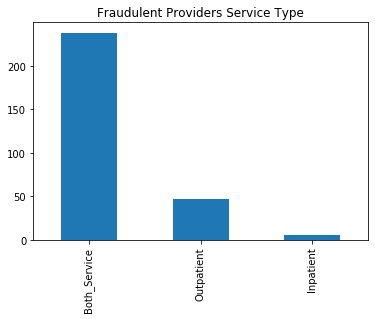

In [47]:
#dataset['frag_family'].value_counts().plot(kind = 'pie', autopct = '%1.1f%%', colors = colors)
features[features.PotentialFraud == 'Yes']['Service_Type'].value_counts().plot(kind = 'bar')
plt.title('Fraudulent Providers Service Type')

Text(0.5, 1.0, 'Non-Fraudulent Providers Service Type')

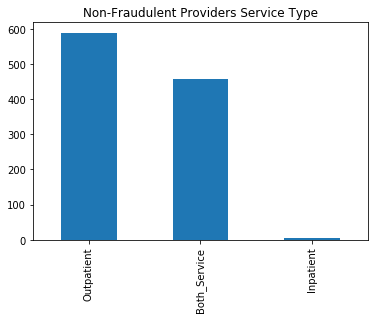

In [48]:
features[features.PotentialFraud == 'No']['Service_Type'].value_counts().plot(kind = 'bar')
plt.title('Non-Fraudulent Providers Service Type')

In [49]:
full_df2.groupby('PotentialFraud')['State'].value_counts()

PotentialFraud  State
0               45       37682
                10       33998
                5        30296
                33       26689
                14       23374
                         ...  
1               43         391
                2          339
                9          304
                41         256
                35         136
Name: State, Length: 104, dtype: int64

In [50]:
features.head()

,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,Both_Service,Inpatient,Outpatient,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,Gender2,Race1,Race2,Race3,Race5,ChronicCond_Alzheimer,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,PotentialFraud
0,PRV51017,114,420,763,Outpatient,0,0,1,496,0.65,1.460026,276.199214,72,183,237,336,82,1,1,1193,1203,1427,1284,1218,1001,944,1253,1327,1453,No
1,PRV51081,4,131,364,Both_Service,1,0,0,328,0.90,1.634615,666.395604,70,62,69,105,23,1,2,555,531,696,627,568,472,427,627,629,678,No
2,PRV51123,21,28,43,Both_Service,1,0,0,24,0.56,3.069767,1090.511628,69,15,13,23,1,3,1,66,69,85,69,66,52,55,82,71,85,No
3,PRV51139,34,42,60,Both_Service,1,0,0,34,0.57,2.566667,1598.000000,74,18,24,34,4,3,1,98,95,111,104,85,73,72,103,108,115,No
4,PRV51140,6,394,697,Both_Service,1,0,0,420,0.60,2.226686,1060.065997,72,189,205,355,9,21,9,1113,1112,1282,1156,1095,888,873,1178,1158,1314,No


Text(0, 0.5, 'Average Age')

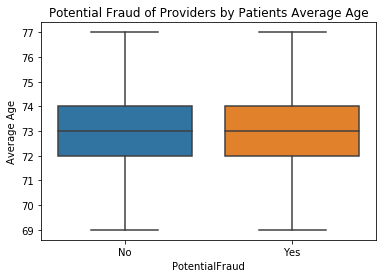

In [51]:
sns.boxplot(x = 'PotentialFraud', y = 'Avg_Age', data = features, showfliers = False)
plt.title('Potential Fraud of Providers by Patients Average Age')
plt.ylabel('Average Age')

Text(0.5, 0, '')

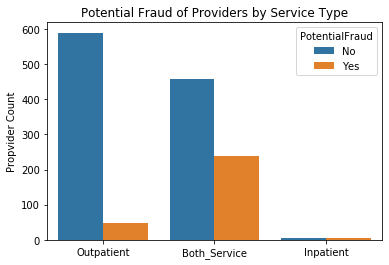

In [70]:
sns.countplot(x="Service_Type", data = features, hue= 'PotentialFraud')
plt.title('Potential Fraud of Providers by Service Type')
plt.ylabel('Propvider Count')
plt.xlabel('')

Text(0, 0.5, 'Number of Patients Per Provider')

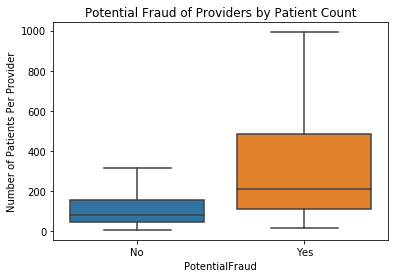

In [71]:
sns.boxplot(x='PotentialFraud', y='Patient_Count', data=features, showfliers=False)
plt.title('Potential Fraud of Providers by Patient Count')
plt.ylabel('Number of Patients Per Provider')